# Water Potability Classifier
-------

Dataset originallly from [Kaggle](https://www.kaggle.com/adityakadiwal/water-potability)

Target is Potability, 1 is drinkable, 0 is not.

In [3]:
import pandas as pd
import seaborn as sns

In [4]:
df = pd.read_csv("gs://harmon_mlprojects/water_potability.csv")

In [5]:
df.head()

,ph,Hardness,Solids,Chloramines,Sulfate,Conductivity,Organic_carbon,Trihalomethanes,Turbidity,Potability
0,NaN,204.890455,20791.318981,7.300212,368.516441,564.308654,10.379783,86.990970,2.963135,0
1,3.716080,129.422921,18630.057858,6.635246,NaN,592.885359,15.180013,56.329076,4.500656,0
2,8.099124,224.236259,19909.541732,9.275884,NaN,418.606213,16.868637,66.420093,3.055934,0
3,8.316766,214.373394,22018.417441,8.059332,356.886136,363.266516,18.436524,100.341674,4.628771,0
4,9.092223,181.101509,17978.986339,6.546600,310.135738,398.410813,11.558279,31.997993,4.075075,0


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3276 entries, 0 to 3275
Data columns (total 10 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   ph               2785 non-null   float64
 1   Hardness         3276 non-null   float64
 2   Solids           3276 non-null   float64
 3   Chloramines      3276 non-null   float64
 4   Sulfate          2495 non-null   float64
 5   Conductivity     3276 non-null   float64
 6   Organic_carbon   3276 non-null   float64
 7   Trihalomethanes  3114 non-null   float64
 8   Turbidity        3276 non-null   float64
 9   Potability       3276 non-null   int64  
dtypes: float64(9), int64(1)
memory usage: 256.1 KB


Count number of nulls

In [6]:
df.isnull().sum(axis = 0)

ph                 491
Hardness             0
Solids               0
Chloramines          0
Sulfate            781
Conductivity         0
Organic_carbon       0
Trihalomethanes    162
Turbidity            0
Potability           0
dtype: int64

Class sizes

<AxesSubplot:title={'center':'Class Counts'}>

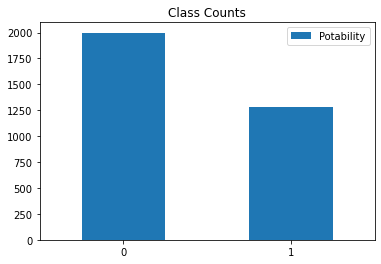

In [7]:
df["Potability"].value_counts().plot(kind="bar", title="Class Counts", legend=True,rot=0) 

In [10]:
from sklearn.model_selection import train_test_split

X = df[df.columns[:-1]]
y = df["Potability"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=42)

see if train test split has consistent distribution of nulls

In [11]:
null_dist_df = (100 * X.isnull().sum(axis = 0) / X.shape[0]).to_frame(name="original")
null_dist_df["train"] = (100 * X_train.isnull().sum(axis = 0) / X_train.shape[0])
null_dist_df["test"]  = (100 * X_test.isnull().sum(axis = 0) / X_test.shape[0])

In [12]:
null_dist_df = null_dist_df.reset_index().rename(columns={"index":"feature"})

Want to show in Seaborn with grouped box plot so put in long form using melt.

In [13]:
null_dist_df.melt(id_vars="feature").head()

,feature,variable,value
0,ph,original,14.987790
1,Hardness,original,0.000000
2,Solids,original,0.000000
3,Chloramines,original,0.000000
4,Sulfate,original,23.840049


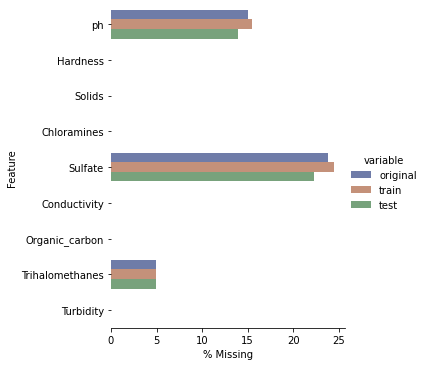

In [98]:
g = sns.catplot(
    data=null_dist_df.melt(id_vars="feature"), kind="bar",
    x="value", y="feature", hue="variable",
    ci="sd", palette="dark", alpha=.6, height=5,  orient='h',
    legend=True, legend_out=True
)
g.despine(left=True)
g.set_axis_labels("% Missing", "Feature")

Create long form of dataset to see distribution

In [16]:
train_df = X_train.merge(y_train, left_index=True, right_index=True)
long_df = train_df.melt(id_vars="Potability")

In [17]:
long_df.head()

,Potability,variable,value
0,0,ph,NaN
1,1,ph,7.203439
2,1,ph,NaN
3,0,ph,6.056818
4,0,ph,9.581189


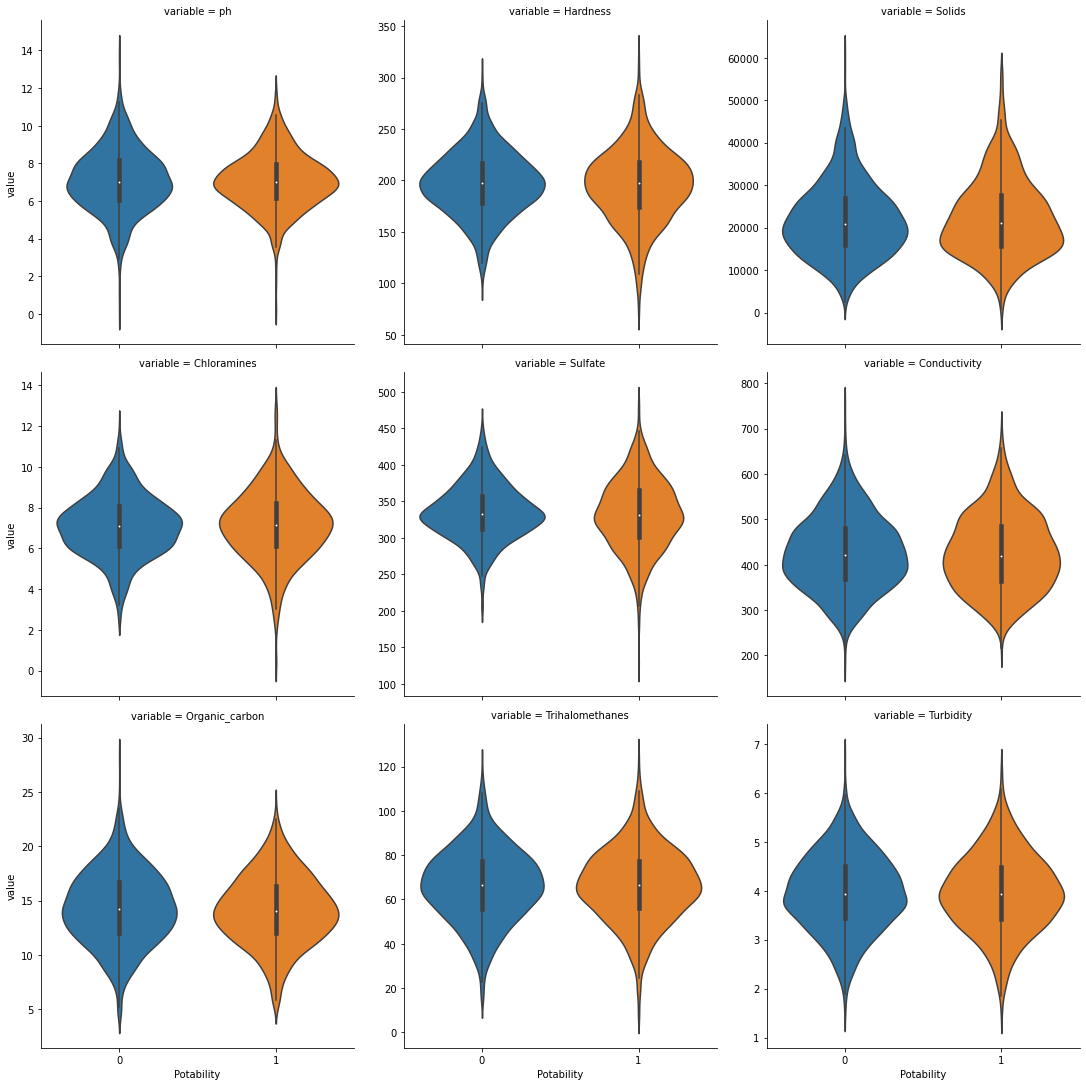

In [18]:
sns.catplot(
    data=long_df, x='Potability', y='value',
    col='variable', kind='violin', col_wrap=3, 
    sharey=False
)

Some features have skew... meaning we should probably look to use median for imputing missing values over mean.

/home/mdh266/.conda/envs/py38/lib/python3.8/site-packages/seaborn/axisgrid.py:1969: UserWarning: The `size` parameter has been renamed to `height`; please update your code.
  warnings.warn(msg, UserWarning)


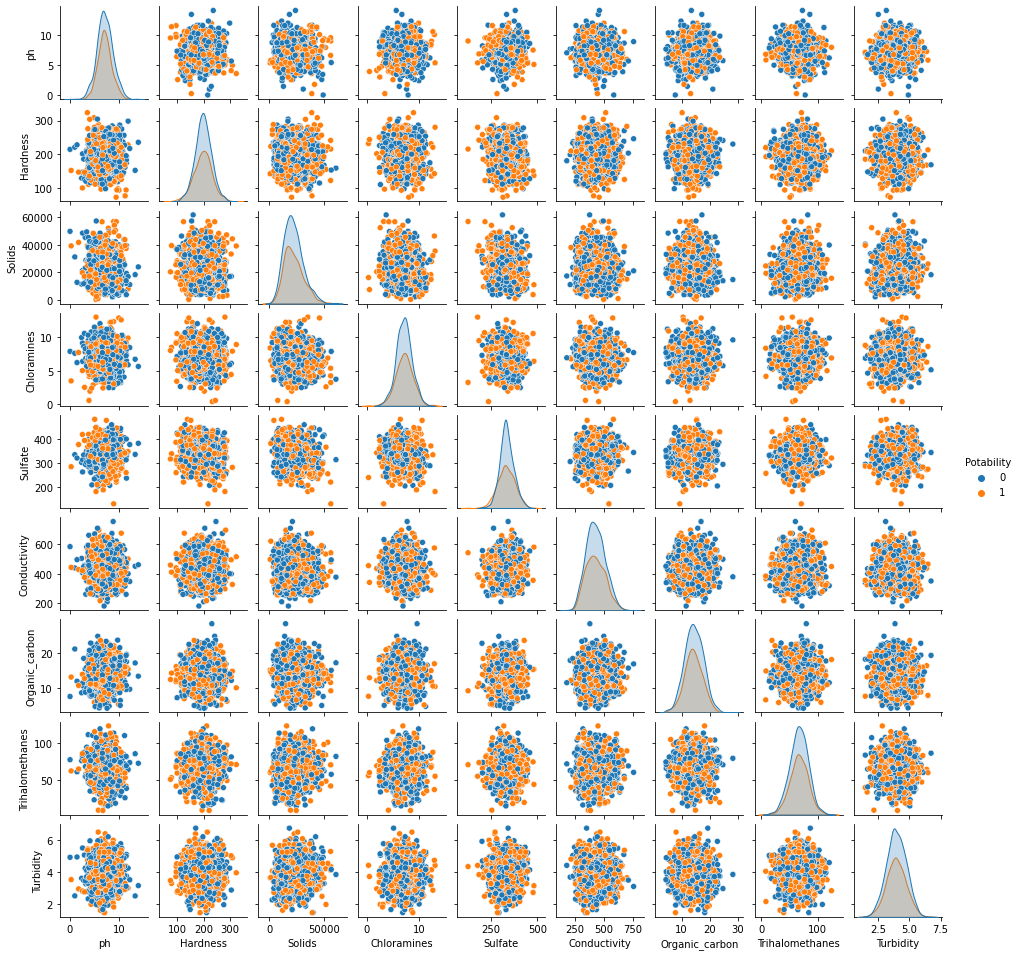

In [225]:
sns.pairplot(train_df,
             vars=X_train.columns,
             size=1.5,
             hue='Potability')

No clear relationship between features so will need flexible model.. will start out with KNN

In [19]:
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import make_pipeline, Pipeline
from sklearn.model_selection import cross_validate

In [20]:
from sklearn.neighbors import KNeighborsClassifier

# Basic Model: K-Nearest Neighbors

In [232]:
nn_X_train = train_df.dropna().drop("Potability",axis=1)
nn_Y_train = train_df.dropna()["Potability"]
knn_pipe = make_pipeline(StandardScaler(), KNeighborsClassifier())

scores = cross_validate(knn_pipe, nn_X_train, nn_Y_train, cv=5, 
                        scoring=('accuracy', 'precision','recall','roc_auc'))

print("accuracy: {}".format(scores['test_accuracy'].mean()))
print("roc_auc: {}".format(scores['test_roc_auc'].mean()))
print("precision: {}".format(scores['test_precision'].mean()))
print("recall: {}".format(scores['test_recall'].mean()))

accuracy: 0.6161159420289855
roc_auc: 0.6301620318304857
precision: 0.5422232088898756
recall: 0.3943109987357775


## Investigate Null Values

In [44]:
nulls_per_class = (
    X_train.isnull()
           .merge(y_train, left_index=True, right_index=True)
           .groupby("Potability").sum()
           .merge(y_train.value_counts().to_frame("count"), left_index=True, right_index=True)
            [["ph","Sulfate","Trihalomethanes","count"]]
)

In [45]:
for col in nulls_per_class.columns:
    if col != "count":
        nulls_per_class[col] = 100 *nulls_per_class[col] / nulls_per_class["count"]

In [46]:
nulls_per_class

,ph,Sulfate,Trihalomethanes,count
Potability,,,,
0,15.423606,25.416365,5.575670,1381
1,15.460526,23.135965,3.947368,912


## Dimensionality Reduction

In [195]:
from sklearn.decomposition import PCA

In [199]:
pca_pipe = Pipeline([("scaler", StandardScaler()),
                      ("pca",PCA(n_components=nn_X_train.shape[1]))])

pca_pipe = pca_pipe.fit(nn_X_train) 
pca_pipe["pca"].explained_variance_ratio_

array([0.13515957, 0.13069138, 0.1164915 , 0.11429207, 0.11115061,
       0.10782748, 0.10268729, 0.09795869, 0.08374142])

In [47]:
from sklearn.model_selection import GridSearchCV
from sklearn.impute       import SimpleImputer

# define the parameter values
params = {"knn__n_neighbors" : [1,3,5,7,10,15,20,25,30],
          "knn__weights" : ["uniform", "distance"],
          "imputer__strategy":["mean","median"]
}

knn_pipe = Pipeline([("imputer", SimpleImputer()),
                     ("imbal", SMOTE()),
                     ("scaler", StandardScaler()),
                     ("knn", KNeighborsClassifier())])

In [48]:
knn_grid   = GridSearchCV(estimator   = knn_pipe,
                          param_grid  = params,
                          scoring     = "roc_auc",
                          cv          = 5,
                          n_jobs      =-1)

knn_model = knn_grid.fit(X_train, y_train)

In [51]:
knn_model.best_estimator_

Pipeline(steps=[('imputer', SimpleImputer(strategy='median')),
                ('scaler', StandardScaler()),
                ('knn',
                 KNeighborsClassifier(n_neighbors=30, weights='distance'))])

In [49]:
scores = cross_validate(knn_model.best_estimator_, X_train, y_train, cv=5, 
                        scoring=('accuracy', 'precision','recall','roc_auc'))

print("accuracy: {}".format(scores['test_accuracy'].mean()))
print("roc_auc: {}".format(scores['test_roc_auc'].mean()))
print("precision: {}".format(scores['test_precision'].mean()))
print("recall: {}".format(scores['test_recall'].mean()))

accuracy: 0.6432685446813368
roc_auc: 0.6560617124029461
precision: 0.6397993287654427
recall: 0.23581336696090793


In [70]:
from imblearn.over_sampling import RandomOverSampler, ADASYN
from imblearn.pipeline       import Pipeline 

params = {"knn__n_neighbors" : [1,3,5,7,10,15,20,25,30],
          "knn__weights" : ["uniform", "distance"],
          "imputer__strategy":["mean","median"]
}

knn_pipe2 = Pipeline([("imputer", SimpleImputer()),
                     ("balancer", RandomOverSampler(sampling_strategy="minority",random_state=42)),
                     ("scaler", StandardScaler()),
                     ("knn", KNeighborsClassifier())])

knn_grid2   = GridSearchCV(estimator   = knn_pipe2,
                          param_grid  = params,
                          scoring     = "roc_auc",
                          cv          = 5,
                          n_jobs      =-1)

knn_model2 = knn_grid2.fit(X_train, y_train)

In [71]:
scores = cross_validate(knn_model2.best_estimator_, X_train, y_train, cv=5, 
                        scoring=('accuracy', 'precision','recall','roc_auc'))

print("accuracy: {}".format(scores['test_accuracy'].mean()))
print("roc_auc: {}".format(scores['test_roc_auc'].mean()))
print("precision: {}".format(scores['test_precision'].mean()))
print("recall: {}".format(scores['test_recall'].mean()))

accuracy: 0.613611325170534
roc_auc: 0.6442169852862774
precision: 0.5139956831159679
recall: 0.5176424668227947


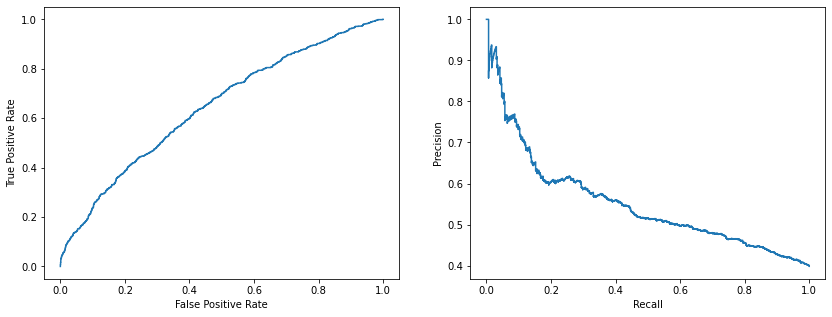

In [73]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import PrecisionRecallDisplay
import matplotlib.pyplot as plt

scores = cross_val_predict(knn_model2.best_estimator_, X_train, y_train, method="predict_proba")

fpr, tpr, thresholds = roc_curve(y_train, scores[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_train, scores[:,1])


pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

## Random Forest

In [113]:
from sklearn.model_selection import GridSearchCV
from sklearn.impute import SimpleImputer
from lightgbm.sklearn import LGBMClassifier

# define the parameter values
params = {"rf__n_estimators": [100,150,200,300,400,500],
          "rf__max_depth": [5,10,15,20,25],
          "rf__bagging_fraction": [0.2, 0.4, 0.8],
          "rf__feature_fraction": [0.2, 0.4, 0.8],
          "rf__is_unbalanced": [True, False]
}

rf_pipe = Pipeline([("rf", LGBMClassifier(boosting_type="rf",
                                          bagging_freq=1))])

In [114]:
rf_grid   = GridSearchCV(estimator   = rf_pipe,
                         param_grid  = params,
                         scoring     = "roc_auc",
                         cv          = 5,
                         n_jobs      =-1)

rf_model = rf_grid.fit(X_train, y_train)

In [115]:
rf_model.best_estimator_

Pipeline(steps=[('rf',
                 LGBMClassifier(bagging_fraction=0.8, bagging_freq=1,
                                boosting_type='rf', feature_fraction=0.8,
                                is_unbalanced=True, max_depth=15,
                                n_estimators=150))])

In [116]:
scores = cross_validate(rf_model.best_estimator_, X_train, y_train, cv=5, n_jobs=-1,
                        scoring=('accuracy', 'precision','recall','roc_auc'))

print("accuracy: {}".format(scores['test_accuracy'].mean()))
print("roc_auc: {}".format(scores['test_roc_auc'].mean()))
print("precision: {}".format(scores['test_precision'].mean()))
print("recall: {}".format(scores['test_recall'].mean()))

accuracy: 0.6480634757542028
roc_auc: 0.6460606489504725
precision: 0.6590067868242419
recall: 0.2369002582117336


In [ ]:
Pipeline(["i"])

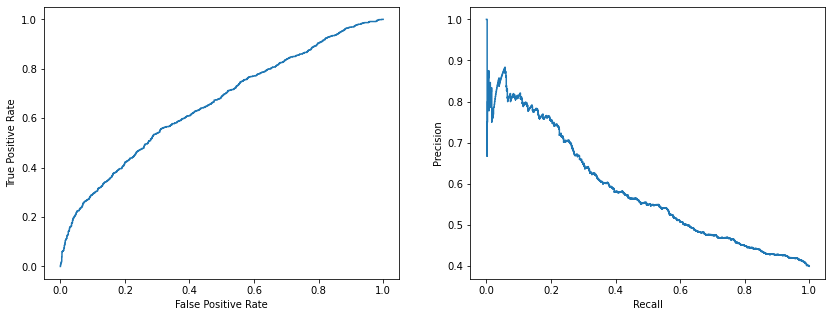

In [84]:
scores = cross_val_predict(rf_model.best_estimator_, X_train, y_train, method="predict_proba", n_jobs=-1)

fpr, tpr, thresholds = roc_curve(y_train, scores[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_train, scores[:,1])


pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()

## LightGBM 

In [86]:

from sklearn.model_selection import 

In [96]:
# define the parameter values
lgb_params = {"n_estimators": [100,200,300,400,500,600],
             "boosting_type": ["goss"],
             "subsample" : [0.5, 0.66, 1.0],
             "colsample_bytree": [0.5, 0.66, 1.0],
             "reg_alpha": [0,0.1,0.2],
             "reg_lambda": [0,0.1,0.2]
              
}

# define the grid search and optimization metric
lgb_grid = GridSearchCV(estimator=LGBMClassifier(class_weight="balanced"),
                    param_grid=lgb_params,
                    scoring="roc_auc",
                    cv=5)

# perform the grid search
lgb_model = lgb_grid.fit(X_train, y_train)

KeyboardInterrupt: 

In [93]:
lgb_model.best_estimator_

LGBMClassifier(boosting_type='goss', is_unbalance=True, n_estimators=300,
               subsample=0.5)

In [90]:
scores = cross_validate(lgb_model.best_estimator_, X_train, y_train, cv=5, 
                        scoring=('accuracy', 'precision','recall','roc_auc'))

print("accuracy: {}".format(scores['test_accuracy'].mean()))
print("roc_auc: {}".format(scores['test_roc_auc'].mean()))
print("precision: {}".format(scores['test_precision'].mean()))
print("recall: {}".format(scores['test_recall'].mean()))

accuracy: 0.6162047740008181
roc_auc: 0.6264928695776337
precision: 0.5203978379809449
recall: 0.48904701855521526


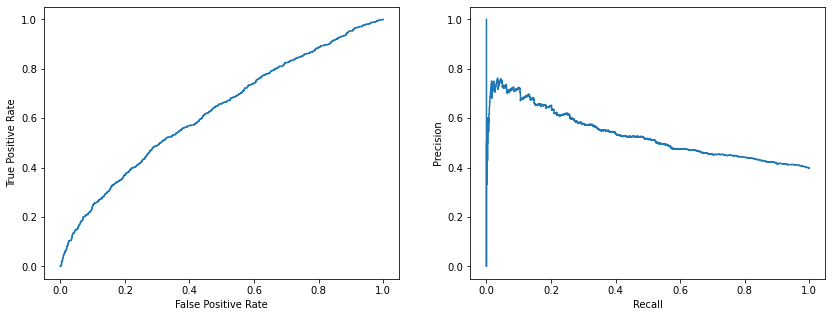

In [91]:
scores = cross_val_predict(lgb_model.best_estimator_, X_train, y_train, method="predict_proba")

fpr, tpr, thresholds = roc_curve(y_train, scores[:,1])
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr)

prec, recall, _ = precision_recall_curve(y_train, scores[:,1])


pr_display = PrecisionRecallDisplay(precision=prec, recall=recall)

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

roc_display.plot(ax=ax1)
pr_display.plot(ax=ax2)
plt.show()